This is based on [Journal of The Electrochemical Society, 152 􏰀5􏰁 D79-D87 􏰀2005􏰁] by M. Verbrugge and P. Liu.
It illustrates how easy it is to specify complex operating conditions for energy storage devices in `pycap`.

In [1]:
import pycap
import numpy
from matplotlib import pyplot
%matplotlib inline

The supercapacitor is initially fully discharged.
It is charged to $1.7\ \mathrm{V}$ at a constant current of $100\ \mathrm{A}$.
Subsequently, a constant $1.4\ \mathrm{V}$ is applied for $5\ \mathrm{s}$
and the supercapacitor is allowed to rest at open circuit potential for $3\ \mathrm{min}$.
This sequence is repeated for a series of charge potentials 
at $0.1\ \mathrm{V}$ increments from $1.8$ to $2.4\ \mathrm{V}$.
The routine defined below, `run_verbrugge_experiment`, implements that experiment 
and records measurements for the time, current and voltage.

In [2]:
def run_verbrugge_experiment(device):
    charge_current=1.65e-3 # ampere
    discharge_voltage=1.4 # volt
    discharge_time=5.0 # second
    rest_time=180.0 # second
    time_step=0.1 # second
    t=0.0
    time=numpy.array([],dtype=float)
    current=numpy.array([],dtype=float)
    voltage=numpy.array([],dtype=float)
    for charge_voltage in numpy.linspace(1.7,2.4,8):
        # constant current charge
        while device.get_voltage()<charge_voltage:
            t+=time_step
            device.evolve_one_time_step_constant_current(time_step,charge_current)
            time=numpy.append(time,t)
            current=numpy.append(current,device.get_current())
            voltage=numpy.append(voltage,device.get_voltage())
        # constant voltage discharge
        tick=t
        while t-tick<discharge_time:
            t+=time_step
            device.evolve_one_time_step_constant_voltage(time_step,discharge_voltage)
            time=numpy.append(time,t)
            current=numpy.append(current,device.get_current())
            voltage=numpy.append(voltage,device.get_voltage())
        # rest at open circuit
        tick=t
        while t-tick<rest_time:
            t+=time_step
            device.evolve_one_time_step_constant_current(time_step,0.0)
            time=numpy.append(time,t)
            current=numpy.append(current,device.get_current())
            voltage=numpy.append(voltage,device.get_voltage())
    data={}
    data['time']=time
    data['current']=current
    data['voltage']=voltage
    return data

Make an energy storage device (here a supercapacitor) and run the experiment.

In [3]:
device_database=pycap.PropertyTree()
device_database.parse_xml('super_capacitor.xml')
# no faradaic processes
device_database.put_double('device.material_properties.electrode_material.exchange_current_density',0.0)
device=pycap.EnergyStorageDevice(device_database)
# run experiment
data=run_verbrugge_experiment(device)

Postprocess the results.

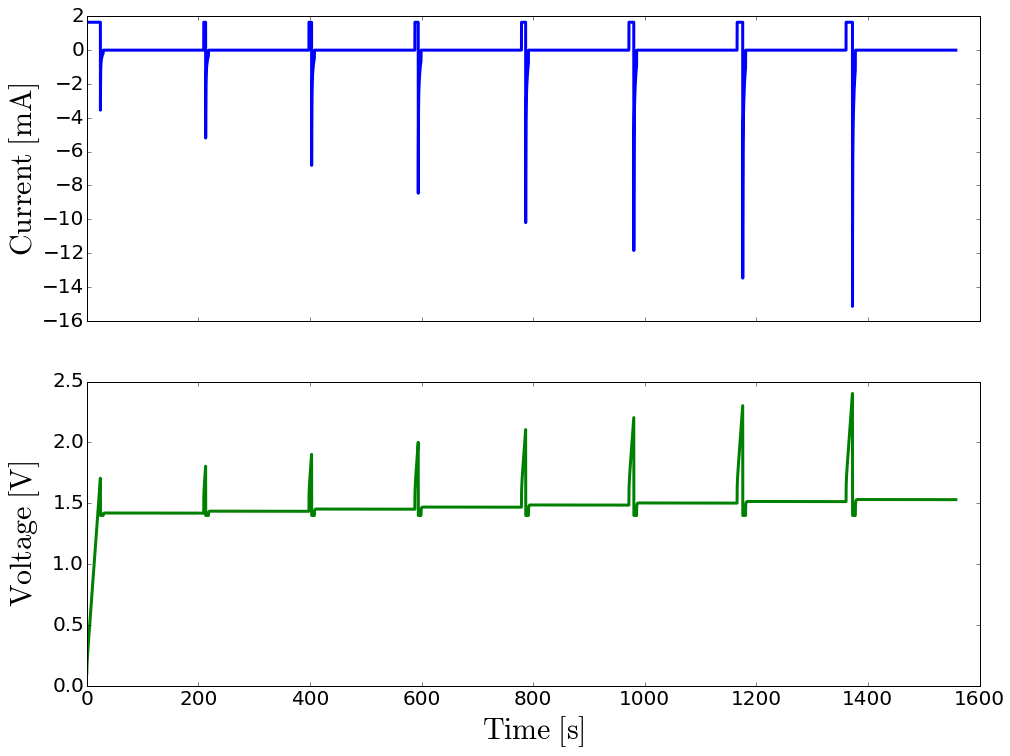

In [4]:
time=data['time']
current=data['current']
voltage=data['voltage']
label_fontsize=30
tick_fontsize=20
labelx=-0.05
labely=0.5
plot_linewidth=3
f,axarr=pyplot.subplots(2,sharex=True,figsize=(16,12))
axarr[0].plot(time,1e+3*current,'b-',lw=plot_linewidth)
axarr[0].set_ylabel(r'$\mathrm{Current\ [mA]}$',fontsize=label_fontsize)
axarr[0].get_yaxis().set_tick_params(labelsize=tick_fontsize)
axarr[0].yaxis.set_label_coords(labelx,labely)
axarr[1].plot(time,voltage,'g-',lw=plot_linewidth)
axarr[1].set_ylabel(r'$\mathrm{Voltage\ [V]}$',fontsize=label_fontsize)
axarr[1].set_xlabel(r'$\mathrm{Time\ [s]}$',fontsize=label_fontsize)
axarr[1].get_yaxis().set_tick_params(labelsize=tick_fontsize)
axarr[1].get_xaxis().set_tick_params(labelsize=tick_fontsize)
axarr[1].yaxis.set_label_coords(labelx,labely)
pyplot.show()

Plot the power versus time.
The red surface area represents the energy used to charge the supercapacitor 
and the green on the power pulses is the energy recovered.

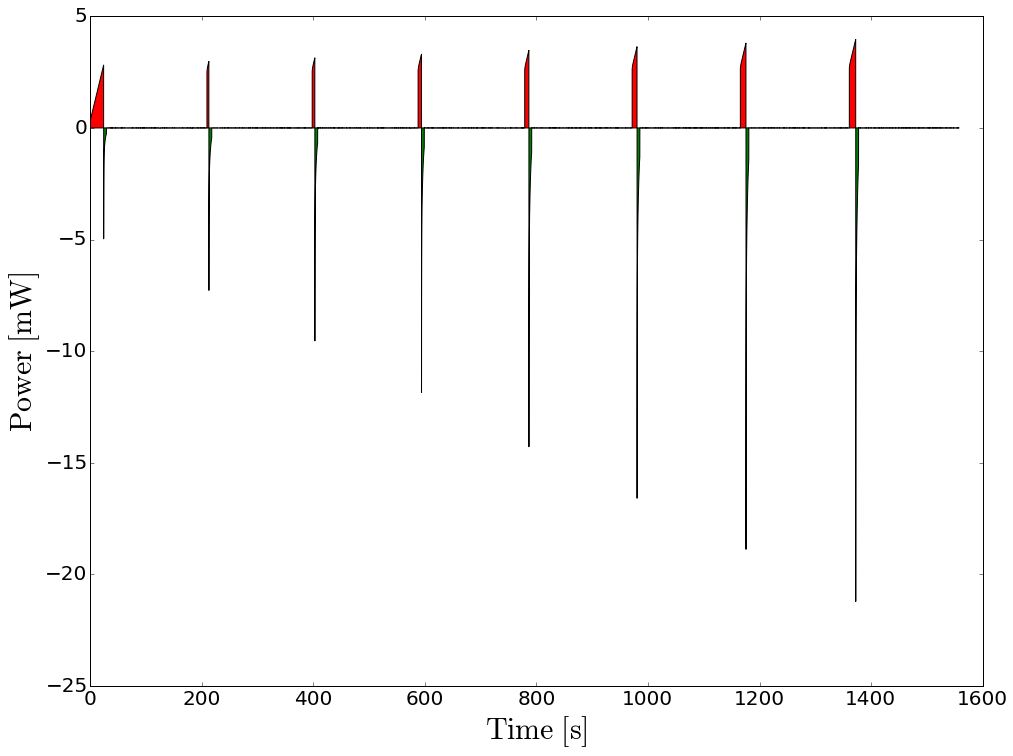

In [5]:
power=current*voltage
pyplot.figure(figsize=(16,12))
pyplot.fill_between(time,1e+3*power,0,where=power>0,facecolor='r')
pyplot.fill_between(time,1e+3*power,0,where=power<0,facecolor='g')
pyplot.xlabel(r'$\mathrm{Time\ [s]}$',fontsize=label_fontsize)
pyplot.ylabel(r'$\mathrm{Power\ [mW]}$',fontsize=label_fontsize)
pyplot.gca().get_xaxis().set_tick_params(labelsize=tick_fontsize)
pyplot.gca().get_yaxis().set_tick_params(labelsize=tick_fontsize)
pyplot.show()